# 폐렴아 기다려라!
## 프로젝트 : 폐렴 진단기 성능개선
### 개요
의료 인공지능은 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용되는데 이 프로젝트에서는 의사처럼 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만드는 것이다. 

폐렴(Pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다.  
폐렴은 쉽게 말해 폐에 염증이 생기는 것이다.  
염증은 쉽게 말해 우리 몸을 지키기 위해 싸우고 있는 장소이며 폐렴이라면 폐에서 바이러스나 세균으로부터 우리 몸을 지키기위해 백혈구들이 싸우고 있는 상황을 말한다.

#### 폐렴 구별법 
![screensh](12_e0QcAmT.png)  
정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다.  
세균성 폐렴(가운데)은 일반적으로 오른쪽 상부 엽(흰색 화살표)에 있는 것을 나타내는 반면,  
바이러스성 폐렴(오른쪽)은 양쪽 폐에서보다 확산된 "interstital(조직 사이에 있는)"패턴으로 나타난다.

위와 같이 폐렴에 걸린 사진들은 특징이 패턴을 이루고 있는 것을 알 수 있다.
따라서 이 이미지에서 폐렴의 특징 패턴을 학습해서 찾아내게 하는 것이 목표다.

#### 데이터셋
이 프로젝트에서 사용할 데이터는 [kaggle의 Chest X-Ray Images](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

데이터의 구성은 3개의 폴더(train/test/val)로 구성되며, 각 이미지 카테고리(폐렴/정상)에 대한 하위 폴더를 포함한다.  
5,856 개의 X-RAY 이미지(JPEG)와 2개의 범주(폐렴/정상)이 있다. 전체 데이터 크기는 총 1.2GB 가량 된다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5세 소아 환자의 흉부 X선 영상이다.

### 목차
1. 탐색적 데이터 분석(EDA; Exploratory Data Analysis) 및 데이터 전처리
2. 베이스 모델 학습 및 평가
3. Data Augmentation을 사용해 베이스 모델과의 성능 비교
4. 변경된 모델과 베이스 모델의 성능 비교
5. ResNet-18 모델 구현

---
#### 1. 탐색적 데이터 분석(EDA; Exploratory Data Analysis) 및 데이터 전처리 
##### 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# GPU 활성화
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
tf.config.list_physical_devices('GPU')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13241796637208375492
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6278873088
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4618083626179880359
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


##### 전역 변수 설정

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "C:/mango/AIffel/AIFFEL_quest_cr/MainQuest/Quest03"
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

C:/mango/AIffel/AIFFEL_quest_cr/MainQuest/Quest03


##### 데이터 불러오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 5216개, test 624개, val 16개로 각각 89%, 10.7%, 0.3% 비율로 나뉘어져 있다.  
val 개수가 부족하기에 train과 val의 데이터를 80:20으로 분할 

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
C:\mango\AIffel\AIFFEL_quest_cr\MainQuest\Quest03\chest_xray\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
C:\mango\AIffel\AIFFEL_quest_cr\MainQuest\Quest03\chest_xray\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상보다 폐렴 이미지 수가 3배 많은 것을 알 수 있다.

학습전 시간 절약을 위해 mini-batch 진행

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.repeat() # batch_size에 맞게 자동으로 데이터를 맞춰준다.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

##### 데이터 시각화

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

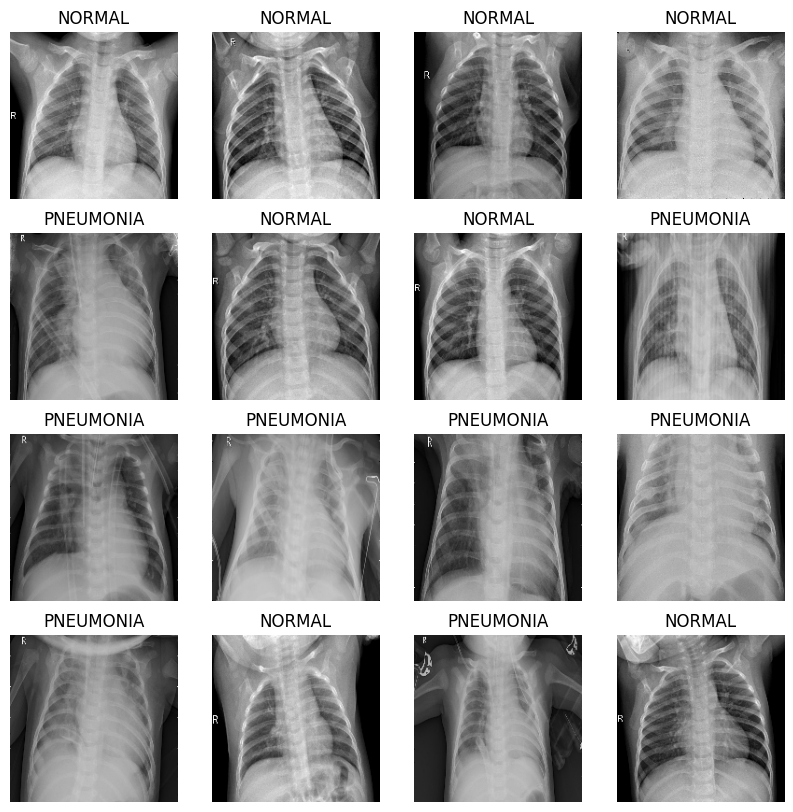

In [17]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

#### 2. 베이스 모델 학습 및 평가

##### CNN 데이터 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### 데이터 imbalance 처리

EDA 중에 Normal 과 Pneumonia 중에 Pneumonia 데이터가 과하게 많이 있었던걸 확인했다.  
이와 같이 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때   imbalance한 데이터의 경우 학습 효과가 떨어진다.  

따라서 이런 문제들을 해결하는 방법으로 [Weight balancing](https://3months.tistory.com/414)이라는 테크닉이 사용된다.  
Weight balancing은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


##### 베이스 모델 학습

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 82s 271ms/step - loss: 0.2734 - accuracy: 0.8906 - precision: 0.9702 - recall: 0.8800 - val_loss: 0.9666 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2277 - accuracy: 0.9080 - precision: 0.9729 - recall: 0.9015 - val_loss: 1.4444 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 50s 194ms/step - loss: 0.1950 - accuracy: 0.9270 - precision: 0.9785 - recall: 0.9221 - val_loss: 0.5264 - val_accuracy: 0.7471 - val_precision: 0.7434 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 90s 347ms/step - loss: 0.1689 - accuracy: 0.9334 - precision: 0.9820 - recall: 0.9277 - val_loss: 0.2564 - val_accuracy: 0.8923 - val_precision: 0.9985 - val_recall: 0.8545
Epoch 5/10
261/261 [==============================] - 82s 316ms/step - loss: 0.1747 - accura

##### 베이스 모델 평가

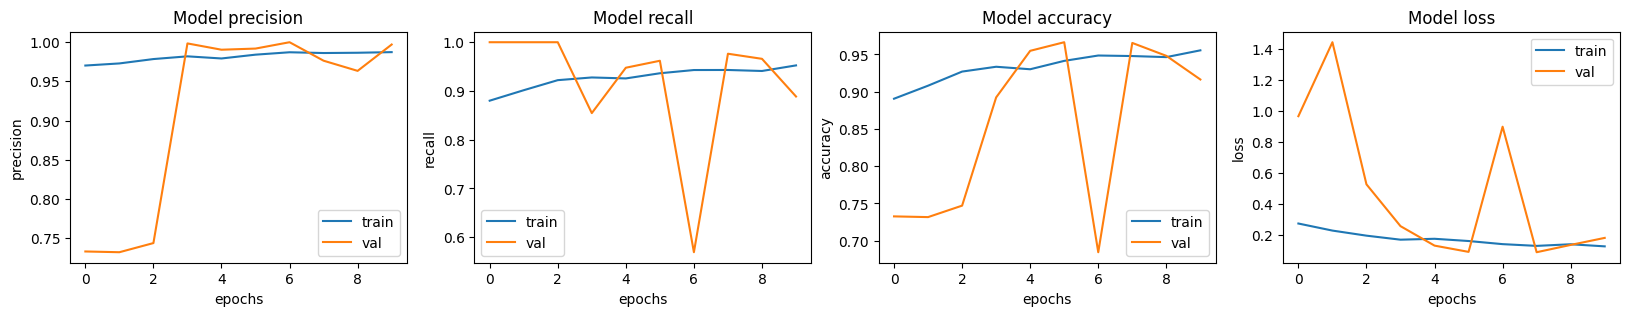

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 11s 250ms/step - loss: 0.5119 - accuracy: 0.8317 - precision: 0.8065 - recall: 0.9615
Loss: 0.511900007724762,
Accuracy: 0.8317307829856873,
Precision: 0.8064516186714172,
Recall: 0.9615384340286255


약 83% 의 정확도를 보인다.

#### 3. Data Augmentation을 사용해 베이스 모델과의 성능 비교

##### 이미지 상하 좌우 반전

In [34]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
def augment(image,label):
    flipped = tf.image.random_flip_left_right(image) # 좌우 반전
    flipped = tf.image.random_flip_up_down(flipped) # 상하 반전
    return flipped,label
    
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,
            num_parallel_calls=AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.repeat() # batch_size에 맞게 자동으로 데이터를 맞춰준다.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

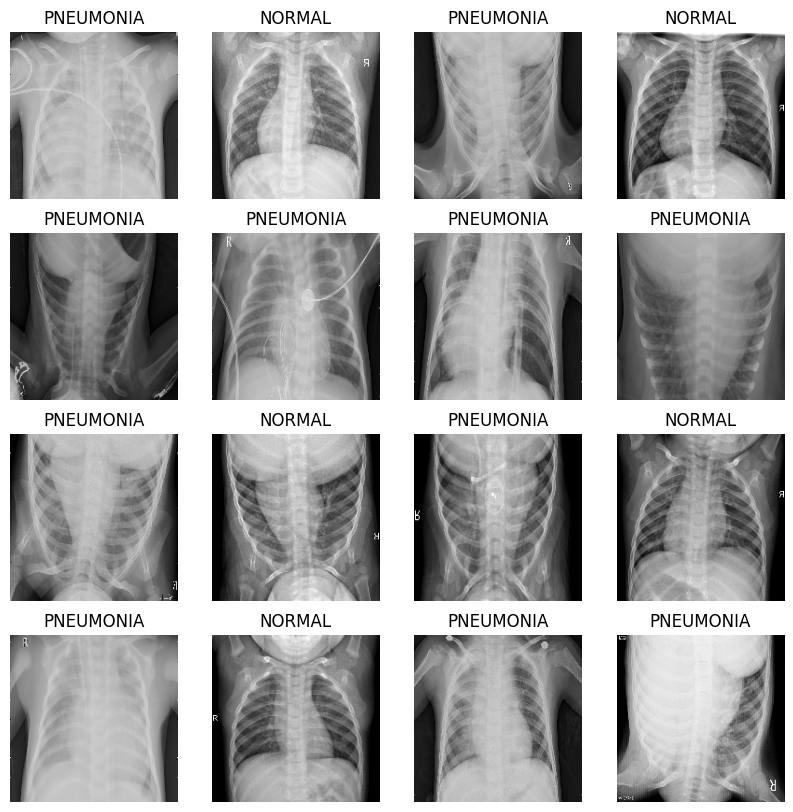

In [21]:
with tf.device('/gpu:0'):
    image_batch, label_batch = next(iter(train_ds)) 
    show_batch(image_batch.numpy(), label_batch.numpy())

In [27]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 112s 297ms/step - loss: 0.4320 - accuracy: 0.7936 - precision: 0.9503 - recall: 0.7625 - val_loss: 0.5776 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 70s 267ms/step - loss: 0.2983 - accuracy: 0.8784 - precision: 0.9646 - recall: 0.8683 - val_loss: 0.7321 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 86s 332ms/step - loss: 0.2470 - accuracy: 0.8992 - precision: 0.9722 - recall: 0.8899 - val_loss: 0.3296 - val_accuracy: 0.8231 - val_precision: 0.8068 - val_recall: 0.9987
Epoch 4/10
261/261 [==============================] - 90s 346ms/step - loss: 0.2255 - accuracy: 0.9064 - precision: 0.9731 - recall: 0.8988 - val_loss: 0.1064 - val_accuracy: 0.9635 - val_precision: 0.9739 - val_recall: 0.9764
Epoch 5/10
261/261 [==============================] - 82s 315ms/step - loss: 0.1924 - accur

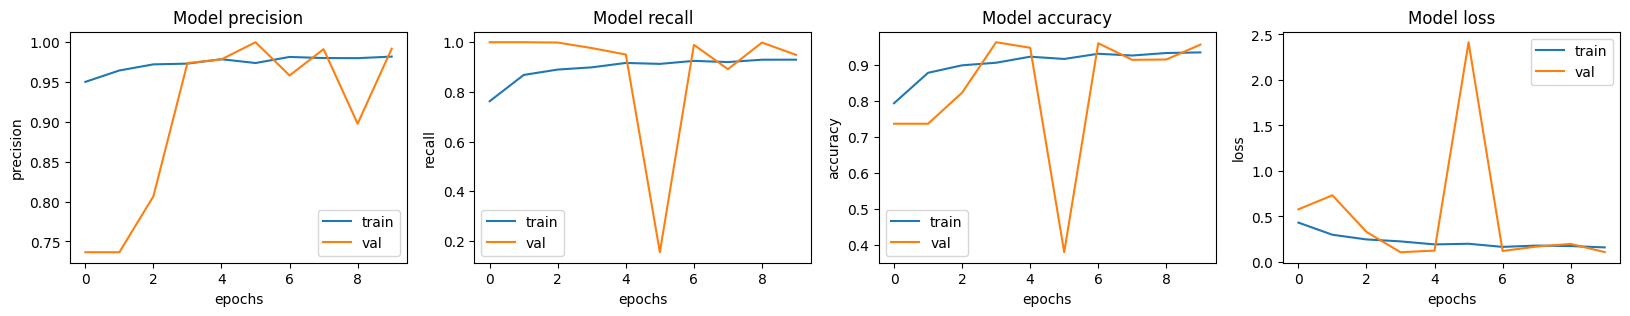

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 8s 182ms/step - loss: 0.4742 - accuracy: 0.8061 - precision: 0.7717 - recall: 0.9795
Loss: 0.4741993546485901,
Accuracy: 0.8060897588729858,
Precision: 0.7717171907424927,
Recall: 0.9794871807098389


기존 베이스 모델을 평가했을 때는 약 83% , 데이터 증강한 데이터로 모델 평가 시에 약 80%의 정확도를 보인다.  
상하좌우 반전으로 Data Augmentation 한 데이터로 기존 베이스 모델과 비교해봤을때  
오히려 약 3% 가량 성능이 더 떨어지는 모습을 보인다.  

##### 이미지 크롭 및 채도 변경

In [44]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
def augment(image,label):
    flipped = tf.image.random_flip_left_right(image) # 좌우 반전
    flipped = tf.image.random_flip_up_down(flipped) # 상하 반전
    cropped = tf.image.central_crop(flipped, central_fraction=0.5) # 이미지 자르고 사이즈 조정
    sturated = tf.image.adjust_saturation(cropped, 3) # 이미지 채도 변경
    
    return sturated,label
    
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,
            num_parallel_calls=AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택한다.
    ds = ds.repeat() # batch_size에 맞게 자동으로 데이터를 맞춰준다.
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

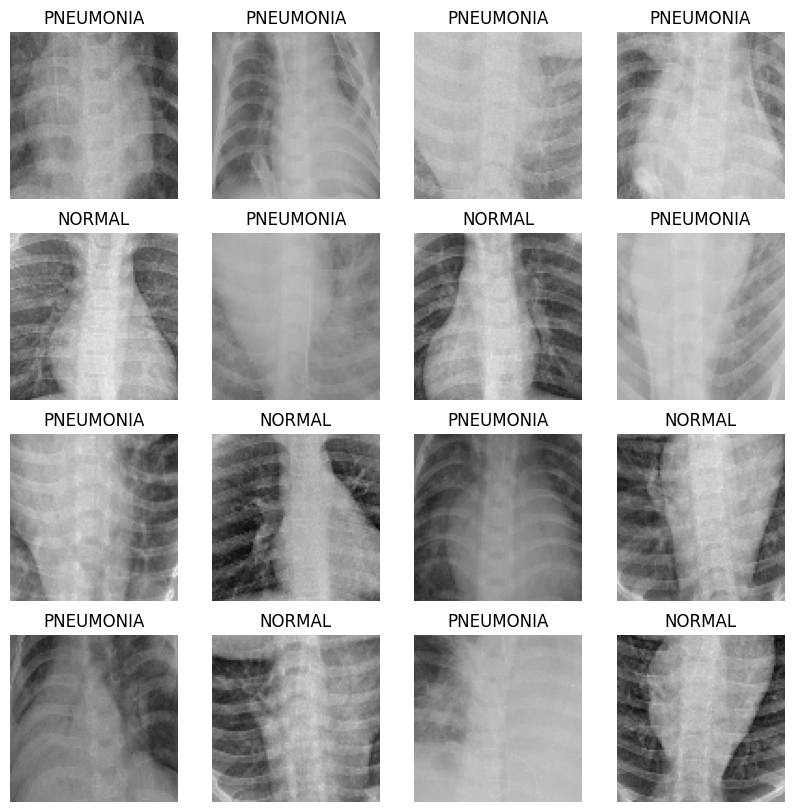

In [16]:
with tf.device('/gpu:0'):
    image_batch, label_batch = next(iter(train_ds)) 
    show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


ValueError: in user code:

    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\keras\engine\input_spec.py", line 296, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 180, 180, 3), found shape=(None, 90, 90, 3)


에러가 발생했지만 시간이 부족해 패스..

##### keras의 ImageDataGenerator

In [21]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.05,
                             height_shift_range=0.05)
train_gen = gen.flow(train_ds)

TypeError: float() argument must be a string or a number, not 'ParallelMapDataset'

ParallelMapDatase이 자꾸 괴롭힘

### 4. 변경된 모델과 베이스 모델의 성능 비교

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), # Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [45]:
with tf.device('/GPU:0'):
    model = build_model()
    model.build(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [46]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 105s 324ms/step - loss: 0.3919 - accuracy: 0.8132 - precision: 0.9564 - recall: 0.7845 - val_loss: 0.3709 - val_accuracy: 0.8519 - val_precision: 0.9984 - val_recall: 0.7997
Epoch 2/10
261/261 [==============================] - 83s 319ms/step - loss: 0.1846 - accuracy: 0.9296 - precision: 0.9818 - recall: 0.9225 - val_loss: 0.1338 - val_accuracy: 0.9462 - val_precision: 0.9784 - val_recall: 0.9476
Epoch 3/10
261/261 [==============================] - 69s 263ms/step - loss: 0.1279 - accuracy: 0.9468 - precision: 0.9872 - recall: 0.9408 - val_loss: 0.1518 - val_accuracy: 0.9404 - val_precision: 0.9889 - val_recall: 0.9295
Epoch 4/10
261/261 [==============================] - 56s 217ms/step - loss: 0.1374 - accuracy: 0.9456 - precision: 0.9871 - recall: 0.9392 - val_loss: 0.1286 - val_accuracy: 0.9606 - val_precision: 0.9879 - val_recall: 0.9582
Epoch 5/10
261/261 [==============================] - 74s 285ms/step - loss: 0.1057 - accur

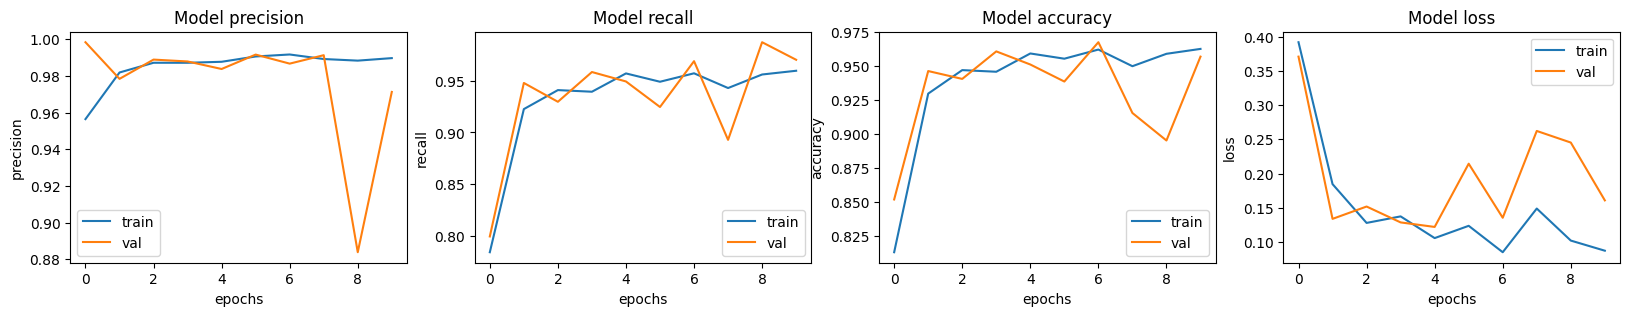

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 9s 200ms/step - loss: 1.2941 - accuracy: 0.7404 - precision: 0.7088 - recall: 0.9923
Loss: 1.2941185235977173,
Accuracy: 0.7403846383094788,
Precision: 0.708791196346283,
Recall: 0.9923076629638672


베이스 모델의 BatchNomarlization 층이 포함된 Cov2D 층과 Dense 층이 아닌 keras의 Conv2D 와 Dense를 불러와 모델을 학습시켰을 시,  
정확도가 약 70% 로 베이스 모델에 비해 10%가량 떨어진 모습을 보인다.

In [54]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(128),
        conv_block(256),
        
        conv_block(512),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(1024, 0.7),
        dense_block(512, 0.5),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [55]:
with tf.device('/GPU:0'):
    model = build_model()
    model.build(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [56]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 185ms/step - loss: 0.3688 - accuracy: 0.8448 - precision: 0.9627 - recall: 0.8232 - val_loss: 0.8471 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 81s 312ms/step - loss: 0.2436 - accuracy: 0.9085 - precision: 0.9706 - recall: 0.9044 - val_loss: 1.3246 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1790 - accuracy: 0.9344 - precision: 0.9797 - recall: 0.9311 - val_loss: 0.1595 - val_accuracy: 0.9327 - val_precision: 0.9193 - val_recall: 0.9961
Epoch 4/10
261/261 [==============================] - 49s 189ms/step - loss: 0.1494 - accuracy: 0.9413 - precision: 0.9821 - recall: 0.9382 - val_loss: 0.1975 - val_accuracy: 0.9019 - val_precision: 0.8822 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1352 - accura

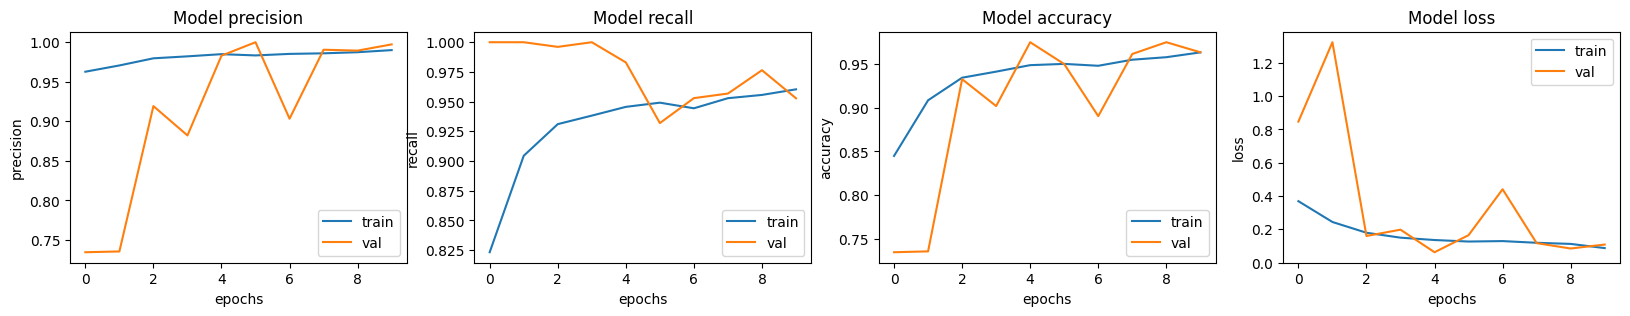

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [58]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 11s 261ms/step - loss: 0.6827 - accuracy: 0.8221 - precision: 0.7900 - recall: 0.9744
Loss: 0.6826978325843811,
Accuracy: 0.8221153616905212,
Precision: 0.790020763874054,
Recall: 0.9743589758872986


베이스 모델과 달리 노드 수를 늘리고 FC-layer 층에 layer 1개를 줄였으나  
정확도가 약 82%로 베이스 모델에 비해 1% 뒤쳐지는 모습이다. 

### ResNet-18 모델 구현

In [33]:
class ResnetBlock(tf.keras.models.Model):
    def __init__(self, filter, down_sample=False):
        super().__init__()
        self.filter = filter
        self.down_sample = down_sample
        self.strides = [2, 1] if down_sample else [1, 1]

        
        self.conv_1 = tf.keras.layers.Conv2D(self.filter, kernel_size=3, strides=self.strides[0], activation='relu', padding="same")
        self.bn_1 = tf.keras.layers.BatchNormalization()
        self.conv_2 = tf.keras.layers.Conv2D(self.filter, kernel_size=3, strides=self.strides[1], activation='relu', padding="same")
        self.bn_2 = tf.keras.layers.BatchNormalization()
        self.merge = tf.keras.layers.Add()

        if self.down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = tf.keras.layers.Conv2D(self.filter, strides=2, kernel_size=(1, 1), padding="same")
            self.res_bn = tf.keras.layers.BatchNormalization()
            
    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        
        if self.down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        out = self.merge([x, res])
        return out

In [36]:
class ResNet18(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_1 = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same")
        self.init_bn = tf.keras.layers.BatchNormalization()
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.flat = tf.keras.layers.Flatten()
        self.fc_3 = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc_3(out)
        return out

In [37]:
with tf.device('/GPU:0'):
    model = ResNet18()
    model.build(input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
model.summary()

Model: "res_net18_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_60 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 resnet_block_24 (ResnetBloc  multiple                 74368     
 k)                                                              
                                                                 
 resnet_block_25 (ResnetBloc  multiple                 74368     
 k)                                                    

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 99s 312ms/step - loss: 0.3584 - accuracy: 0.8661 - precision: 0.9582 - recall: 0.8573 - val_loss: 1.8041 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 69s 263ms/step - loss: 0.2247 - accuracy: 0.9102 - precision: 0.9720 - recall: 0.9054 - val_loss: 1.3832 - val_accuracy: 0.7769 - val_precision: 0.7676 - val_recall: 0.9987
Epoch 3/10
261/261 [==============================] - 67s 258ms/step - loss: 0.2242 - accuracy: 0.9071 - precision: 0.9758 - recall: 0.8973 - val_loss: 8.4371 - val_accuracy: 0.3192 - val_precision: 1.0000 - val_recall: 0.0757
Epoch 4/10
261/261 [==============================] - 77s 295ms/step - loss: 0.1715 - accuracy: 0.9294 - precision: 0.9818 - recall: 0.9221 - val_loss: 1.0998 - val_accuracy: 0.5221 - val_precision: 0.9110 - val_recall: 0.3882
Epoch 5/10
261/261 [==============================] - 85s 327ms/step - loss: 0.1686 - accura

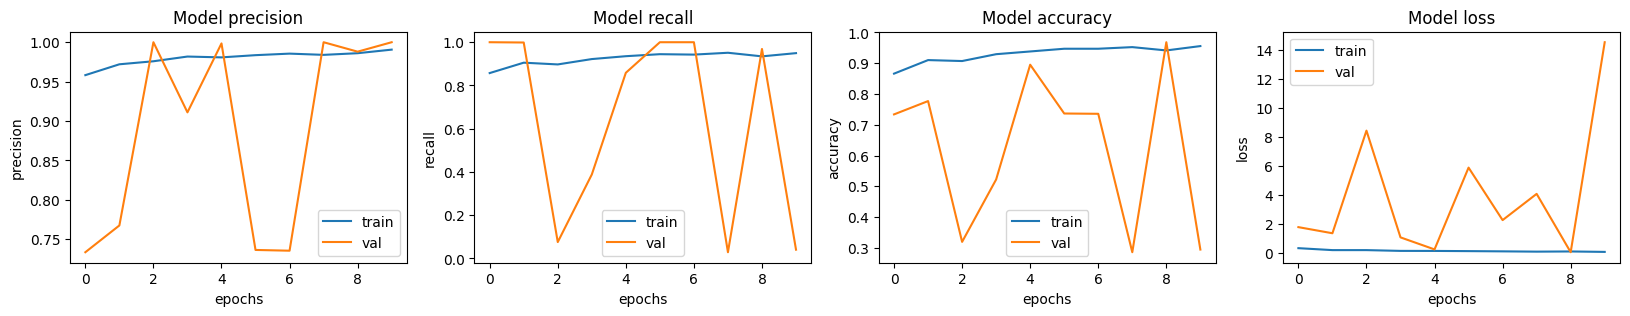

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 11s 252ms/step - loss: 10.7508 - accuracy: 0.4022 - precision: 0.9474 - recall: 0.0462
Loss: 10.75082015991211,
Accuracy: 0.40224358439445496,
Precision: 0.9473684430122375,
Recall: 0.04615384712815285


ResNet18 모델로 학습시켰을 때 정확도가 40%...

In [39]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 92s 277ms/step - loss: 0.3178 - accuracy: 0.8803 - precision: 0.9647 - recall: 0.8711 - val_loss: 2.7928 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 75s 288ms/step - loss: 0.1852 - accuracy: 0.9253 - precision: 0.9765 - recall: 0.9217 - val_loss: 3.2520 - val_accuracy: 0.2798 - val_precision: 1.0000 - val_recall: 0.0222
Epoch 3/10
261/261 [==============================] - 71s 274ms/step - loss: 0.1388 - accuracy: 0.9464 - precision: 0.9816 - recall: 0.9456 - val_loss: 0.1647 - val_accuracy: 0.9288 - val_precision: 0.9323 - val_recall: 0.9738
Epoch 4/10
261/261 [==============================] - 49s 188ms/step - loss: 0.1141 - accuracy: 0.9543 - precision: 0.9851 - recall: 0.9531 - val_loss: 2.4241 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 49s 188ms/step - loss: 0.1090 - accura

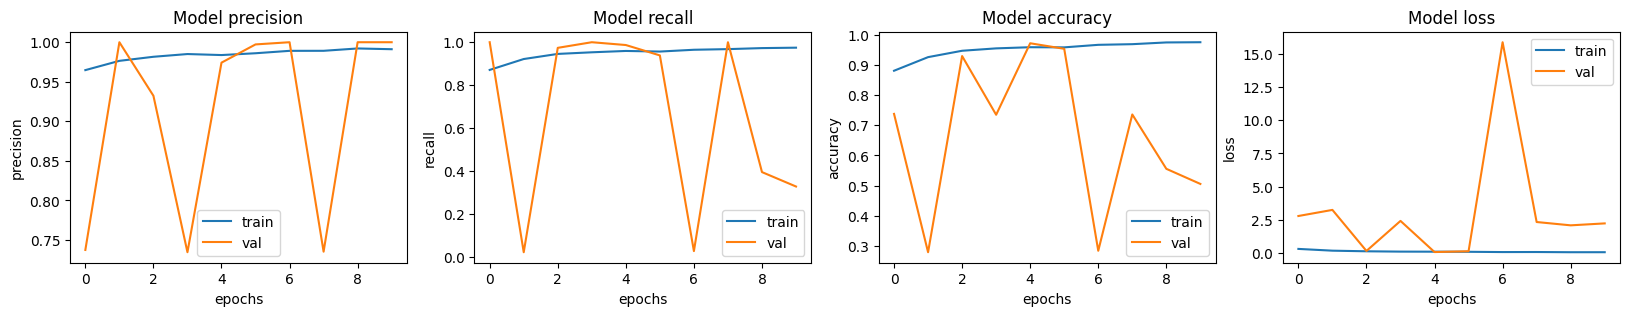

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 10s 254ms/step - loss: 1.2347 - accuracy: 0.6490 - precision: 0.9572 - recall: 0.4590
Loss: 1.2347034215927124,
Accuracy: 0.6490384340286255,
Precision: 0.9572192430496216,
Recall: 0.45897436141967773


기본모델에 못미치지만,  
FC-layer 층에서 1000개 노드의 Dense층 두 개를 제거하니까 정확도가 60%까지 나왔다.

---
### 회고
프로젝트 진행하면서 느낀게 데이터 증강에 대해 가볍게 생각했었는지 몰라도 이해하고 있다고 생각했는데 아직 배워야할 부분이 많다고 느꼈던 것 같습니다.  
데이터 증강 기법에서 GAN에 대해 더 공부할 필요가 있겠다 생각했습니다.  
또한 이번 메인 퀘스트에서는 학습된 모델을 가져오지 않았지만 왠만하면 학습된 모델을 사용하는게 예측 정확도가 확연하게 달라진다는걸 저번 퀘스트에 이어 느꼈습니다.  
마지막으로 제 힘으로 데이터 증강을 하고 모델 구조를 변경하고 ResNet18 모델을 만들어도 기본 모델의 성능도 못따라가는 모습에 아직 실력이 부족한게 많다는 생각이 들었습니다.  

---
#### 참조
[기본적이고 많이 사용되는 데이터 증강 방법(Basic Data Augmentation)](https://doctorham.tistory.com/40)

[Implementing ResNet-18 Using Keras](https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras)

[Beating everything with Depthwise Convolution](https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution)

